# **Project Introduction**

## Background
Engaging in the buying and selling of used cars in Saudi Arabia is quite a fascinating activity. According to information from the website www.pajakku.com, there are some great advantages to be gained when dealing with used cars in Saudi Arabia. One of these perks is the exemption from motor vehicle taxes in the country. This encourages people in Saudi Arabia to sell and purchase used cars within the nation.

When it comes to this economic activity, people generally need a helpful guide to determine the right price for a used car. This helps sellers set a fair price based on the car's specifications and ensures they make a profit. At the same time, potential buyers can also find out the prevailing market prices and make a purchase at the most suitable rate.

In light of this opportunity, a company called Syarah wants to create a friendly online marketplace platform catering to aspiring sellers and buyers of used cars. To meet the market's needs in determining the prices of used cars in Saudi Arabia, Syarah is seeking an IT solution.

## Stakeholder
Syarah Company (an online marketplace company for used cars in Saudi Arabia).

## Problem Statement
Based on the given background, the following problems are formulated:
1. How can we predict the prices of used cars in the Saudi Arabian market?
2. What variables influence the pricing of used cars in the Saudi Arabian market?

## Objectives
Based on the aforementioned problems, the following objectives are formulated to address the issues:
1. Develop a machine learning model for predicting the prices of used cars in the Saudi Arabian market.
2. Identify the variables that significantly affect the pricing of used cars in the Saudi Arabian market.

## Limitations
Clearly, there are some limitations to consider for both of these objectives. The usage of the obtained results will be confined to Syarah Company operating in Saudi Arabia. This is due to the dataset being restricted to the records of used cars in Saudi Arabia maintained exclusively by Syarah Company.

## Metric Evaluation

The metrics for evaluation will include RMSE, MAE, and MAPE.
- RMSE calculates the square root of the average squared errors.
- MAE calculates the average of absolute errors
- MAPE calculates the average percentage error generated by the regression model.

Smaller values of RMSE, MAE, and MAPE indicate a more accurate model in predicting prices.

While taking other metrics into consideration, it is important to note that the main reference metric for determining the value in this case is MAPE. The reason for choosing MAPE in the implemented model is its scale-invariance property. It allows for a fair and standardized comparison of prediction accuracy across different price ranges of used cars. By considering the percentage deviation between predicted and actual prices, MAPE ensures a consistent evaluation of the model's performance.

## Data Information

### Source:

The dataset contains 5624 records of used cars collected from syarah.com. Each row represents a used car. Other information regarding each car is the brand name, model, manufacturing year, origin, options, engine capacity, transmission type, mileage that the car covered, region price, and negotiable.

### Feature:

- Type: Type of used car.
- Region: The region in which the used car was offered for sale.
- Make: The company name.
- Gear_Type: Gear type size of used car.
- Origin: Origin of used car.
- Options: Options of used car.
- Year: Manufacturing year.
- Engine_Size: The engine size of used car.
- Mileage: Mileage of used car	
- Negotiable: True if the price is 0, that means it is negotiable.
- Price: Used car price.

# **Data Understanding**

## Import Library and Dataset

In this part, we begin by importing the necessary libraries and the provided dataset. We also define functions to handle various processes required for building this model.

In [2]:
# Import library yang dibutuhkan untuk eksplorasi dataset
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score,GridSearchCV,RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
dfCleaned = pd.read_csv('data_saudi_used_cars_cleaned.csv')
dfCleaned.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


In [4]:
# Function
def dataDescription(df):
    tempList = []
    for col in df.columns:
        tempList.append(
            [col,
            df[col].dtype,
            df[col].isna().sum(),
            round(df[col].isna().sum()/len(df)*100,2),
            df[col].nunique(),
            #list(df[col].drop_duplicates().sample(5,replace=True).values)
            list(df[col].drop_duplicates().sort_values().values)
            ]
        )

    descData = pd.DataFrame(data = tempList,
                            columns = ['Col','Data Type','Missing Value', 'Pct Missing Value','Num Unique','Unique Sample']
                            )
    display(descData)

def normalCheckShapiro(data):

    _, p_value = stats.shapiro(data)

    alpha = 0.05
    if p_value > alpha:
        print("The data is normally distributed.")
    else:
        print("The data is not normally distributed.")


def fillCentralTendencies(data, field):

    if len(data)<3:
        return data[field].mean()
    
    else:
        _, p_value = stats.shapiro(data[field])

        alpha = 0.05
        if p_value > alpha:
            return data[field].mean()
        else:
            return data[field].median()
        

def cleanExtremeOutliers(dataframe,field,detail=''):
    q1 = dataframe[field].describe()['25%']
    q3 = dataframe[field].describe()['75%']
    IQR = q3 - q1
    lowerBound = q1 - (3*IQR)
    upperBound = q3 + (3*IQR)

    print(f'Jumlah data awal\t= {len(dataframe)}')
    print(f'lower extreme bound\t= {lowerBound}\nupper extreme bound\t= {upperBound}')
    print(f'Jumlah data outliers\t= {len(dataframe[dataframe[field]<lowerBound]) + len(dataframe[dataframe[field]>upperBound])}')

    dfExcludeOutliers = dataframe[dataframe[field].between(lowerBound,upperBound)]
    print(f'Jumlah data (exclude outliers)\t= {len(dfExcludeOutliers)}')

    plt.figure()
    sns.boxplot(dataframe[field].reset_index(drop=True), orient='h')
    plt.title(f'Pesebaran Data {field} {detail}')
    plt.show()

    plt.figure()
    sns.boxplot(dfExcludeOutliers[field].reset_index(drop=True), orient='h')
    plt.title(f'Pesebaran Data {field} {detail} (Extreme Outliers excluded)')
    plt.show()

    return dfExcludeOutliers

## General Information

In this section, we will present general information regarding the data that has been previously cleaned.

In [5]:
display(f'total rows: {len(dfCleaned)}',dfCleaned.describe(), dfCleaned.describe(exclude='number'), dataDescription(dfCleaned))

,Col,Data Type,Missing Value,Pct Missing Value,Num Unique,Unique Sample
0,Type,object,0,0.0,347,"[2, 3, 300, 3008, 301, 360, 4Runner, 5, 500, 5..."
1,Region,object,0,0.0,27,"[Abha, Al-Ahsa, Al-Baha, Al-Jouf, Al-Medina, A..."
2,Make,object,0,0.0,58,"[Aston Martin, Audi, BMW, BYD, Bentley, Cadill..."
3,Gear_Type,object,0,0.0,2,"[Automatic, Manual]"
4,Origin,object,0,0.0,4,"[Gulf Arabic, Other, Saudi, Unknown]"
5,Options,object,0,0.0,3,"[Full, Semi Full, Standard]"
6,Year,int64,0,0.0,50,"[1963, 1964, 1965, 1975, 1977, 1978, 1979, 198..."
7,Engine_Size,float64,0,0.0,71,"[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, ..."
8,Mileage,int64,0,0.0,1714,"[100, 104, 105, 106, 107, 108, 109, 110, 111, ..."
9,Negotiable,bool,0,0.0,2,"[False, True]"


'total rows: 5618'

,Year,Engine_Size,Mileage,Price
count,5618.000000,5618.000000,5.618000e+03,5618.000000
mean,2014.106800,3.295764,1.456360e+05,53103.701139
std,5.778751,1.514054,2.434620e+05,70181.603929
min,1963.000000,1.000000,1.000000e+02,0.000000
25%,2012.250000,2.000000,3.800000e+04,0.000000
50%,2016.000000,3.000000,1.030000e+05,36500.000000
75%,2018.000000,4.500000,1.959142e+05,73000.000000
max,2022.000000,9.000000,4.900000e+06,850000.000000


,Type,Region,Make,Gear_Type,Origin,Options,Negotiable
count,5618,5618,5618,5618,5618,5618,5618
unique,347,27,58,2,4,3,2
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,False
freq,269,2269,1430,4871,4184,2231,3823


None

# **Data Pre-Processing**

In this stage, the previously cleaned data will undergo another round of cleaning by removing any outliers. The approach to eliminating outliers will be based on domain knowledge or by utilizing a boxplot graph to identify and remove data points that fall above the upper or below the lower bound of the data distribution.

In [6]:
df = dfCleaned.copy()

### Negotiable

Information was obtained regarding one of the fields as follows: `Negotiable: True if the price is 0, indicating that it is negotiable.`

In [7]:
df[df['Negotiable']==True][['Negotiable','Price']].value_counts().reset_index()

,Negotiable,Price,count
0,True,0,1795


Based on the explanation of the field above, the learning process may be disrupted due to the presence of a price value of 0 that indicating negotiability. Therefore, it is necessary to drop the field where Negotiable == True from the dataset to avoid any interference with the learning process.

In [8]:
print(f'Total row before drop: {len(df)}')
df.drop(df[df['Negotiable']==True].index,inplace=True)
print(f'Total row after drop: {len(df)}')

Total row before drop: 5618
Total row after drop: 3823


### Price
In this project, we assume that there are no used cars with a price below 5000. Therefore, we will drop any data where the price is below 5000 from the dataset.

In [9]:
print(f'Total row before drop: {len(df)}')
df.drop(df[(df['Price']<5000)&(df['Price']!=0)].sort_values('Price',ascending=False).index,inplace=True)
df.reset_index(drop=True,inplace=True)
print(f'Total row after drop: {len(df)}')
display(df[(df['Price']<5000)&(df['Price']!=0)])

Total row before drop: 3823
Total row after drop: 3755


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In this phase, we will examine and remove any extreme outliers in the Price data through a cleaning process.

Jumlah data awal	= 3755
lower extreme bound	= -141000.0
upper extreme bound	= 272000.0
Jumlah data outliers	= 101
Jumlah data (exclude outliers)	= 3654


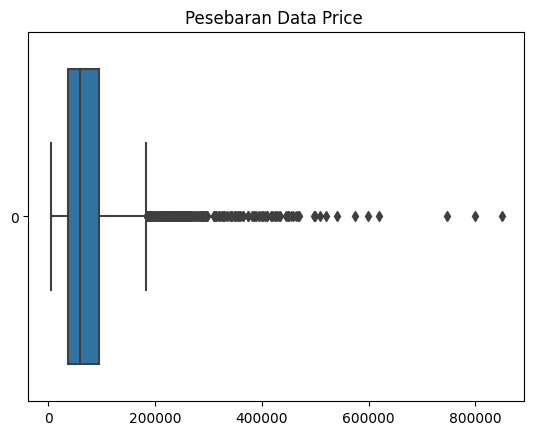

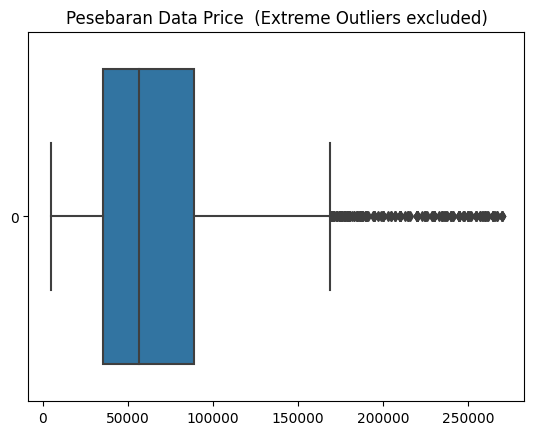

Data after 'Price' cleaning : 3654


In [10]:
df = cleanExtremeOutliers(df,'Price')
print(f"Data after 'Price' cleaning : {len(df)}")

### Engine_Size

In this phase we will check and clean the extreme outliers of the Engine_Size data.

Jumlah data awal	= 3654
lower extreme bound	= -4.0
upper extreme bound	= 10.0
Jumlah data outliers	= 0
Jumlah data (exclude outliers)	= 3654


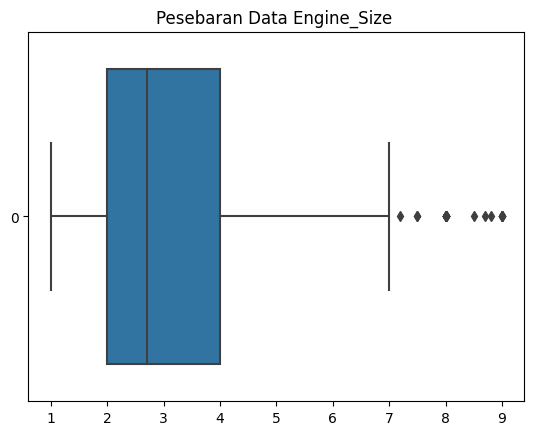

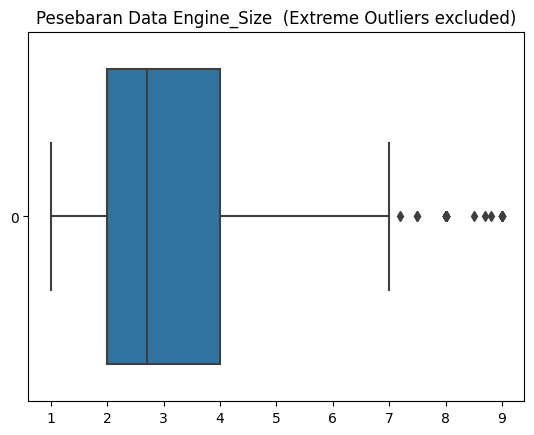

Data after 'Engine_Size' cleaning : 3654


In [11]:
df = cleanExtremeOutliers(df,'Engine_Size')
print(f"Data after 'Engine_Size' cleaning : {len(df)}")

### Mileage

In this phase, we will assess and remove any extreme outliers in the Mileage data through a cleaning process.

Jumlah data awal	= 3654
lower extreme bound	= -352453.0
upper extreme bound	= 593339.75
Jumlah data outliers	= 28
Jumlah data (exclude outliers)	= 3626


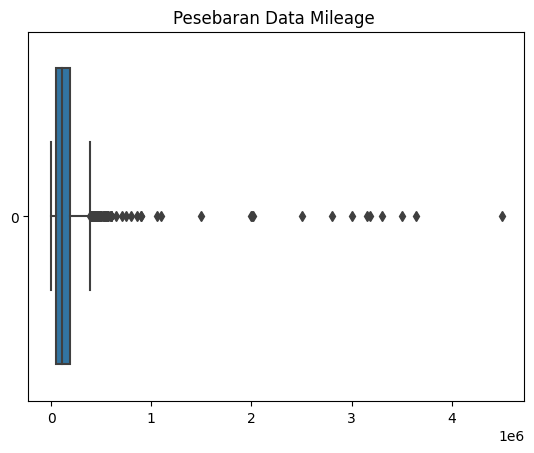

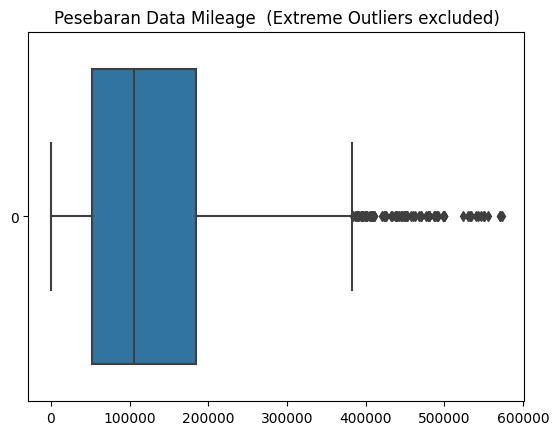

Data after 'Mileage' cleaning : 3626


In [12]:
df = cleanExtremeOutliers(df,'Mileage')
print(f"Data after 'Mileage' cleaning : {len(df)}")

### Year

In this phase, we will assess and remove any extreme outliers in the Year data through a cleaning process.

Jumlah data awal	= 3626
lower extreme bound	= 1998.0
upper extreme bound	= 2033.0
Jumlah data outliers	= 52
Jumlah data (exclude outliers)	= 3574


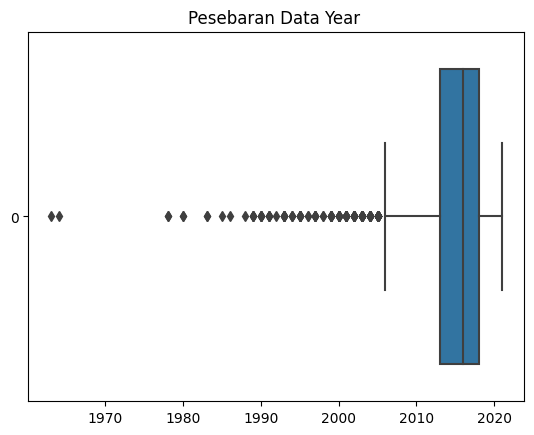

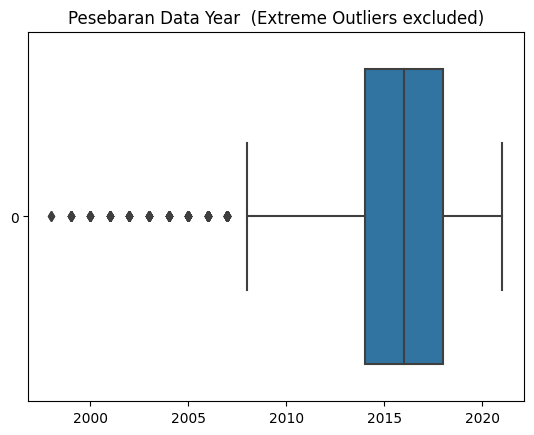

Data after 'Year' cleaning : 3574


In [13]:
df = cleanExtremeOutliers(df,'Year')
print(f"Data after 'Year' cleaning : {len(df)}")

Final Data

# **Exploratory Data Analysis (EDA)**

In [14]:
df.columns

Index(['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'Year',
       'Engine_Size', 'Mileage', 'Negotiable', 'Price'],
      dtype='object')

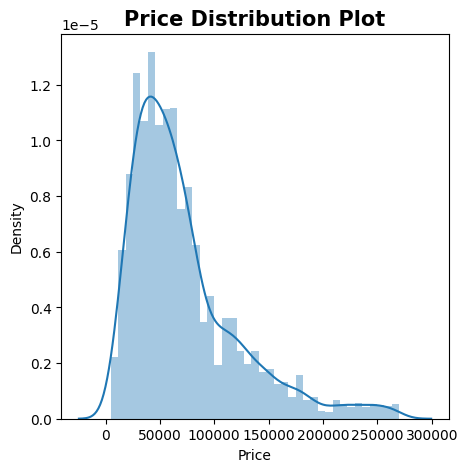

In [15]:
# Plot distribusi fitur 'price'
plt.figure(figsize=(5, 5))
sns.distplot(df['Price'])
plt.title('Price Distribution Plot', size=15, weight='bold')
plt.show()

Based on the distribution plot above, the graph displays a condition of a 'right-skewed distribution.' This indicates that the data is not normally distributed, and the majority of the data is concentrated at values below 150,000.

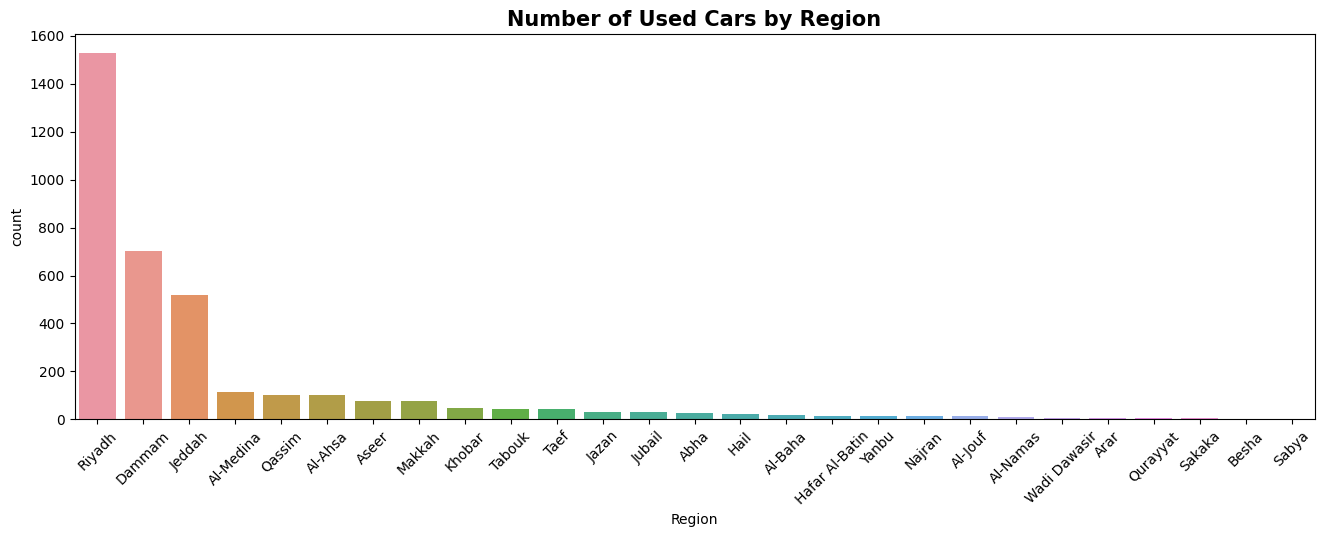

In [16]:
plt.figure(figsize=(16,5))
sns.barplot(
    data=df['Region'].value_counts().reset_index(),
    x = 'Region',
    y = 'count'
)

plt.title('Number of Used Cars by Region',size=15, weight='bold')

plt.xticks(rotation=45)
plt.show()

The above figure shows that used car mainly sale in Riyadh, followed by Dammam and Jeddah. While the other Region giving nearly same small numbers of used cars.

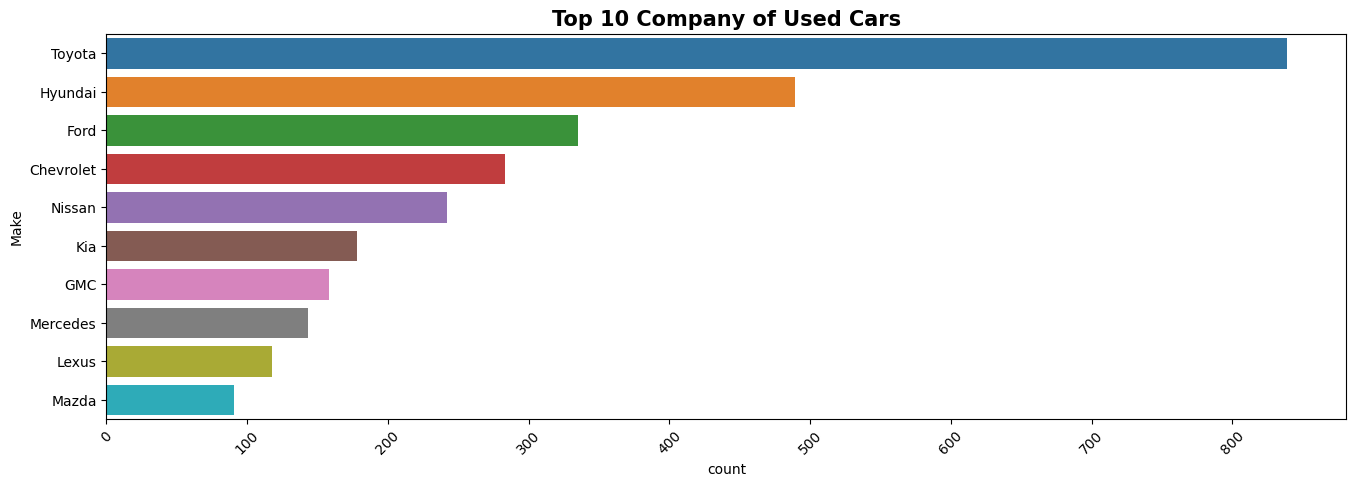

In [17]:
plt.figure(figsize=(16,5))
sns.barplot(
    data=df['Make'].value_counts().reset_index().head(10),
    x = 'count',
    y = 'Make'
)

plt.title('Top 10 Company of Used Cars',size=15, weight='bold')

plt.xticks(rotation=45)
plt.show()

The graph above represents the top 10 brands of used cars available in Saudi Arabia. According to the data, the list is led by Toyota, followed by Hyundai, Ford, and so on. This information suggests that it may be possible to establish pricing based on the availability of cars in the market.

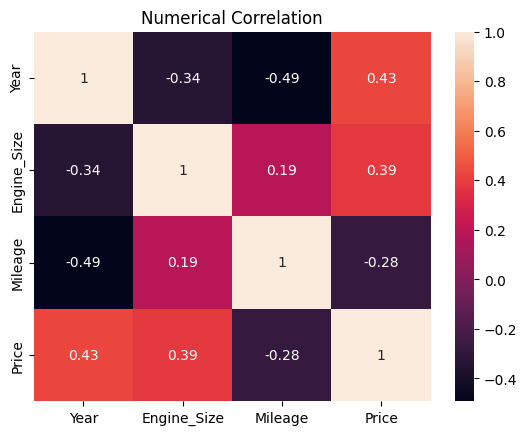

In [18]:
#Numerical Correlation

plt.figure()

sns.heatmap(
    data=df[['Year','Engine_Size', 'Mileage', 'Price']].corr('spearman'),
    annot=True
)
plt.title('Numerical Correlation')
plt.show()

From the data above, Engine Size and Year show a positive medium correlation, while Mileage shows a negative low correlation. This relationship can also be observed from the scatterplot graph below.

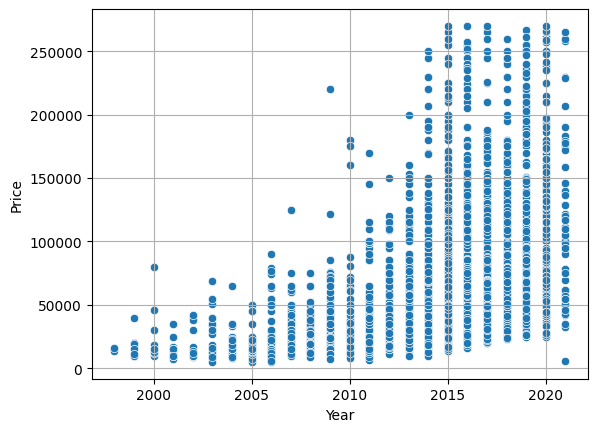

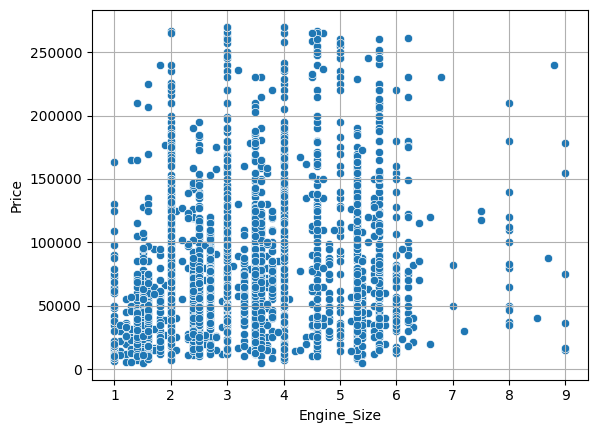

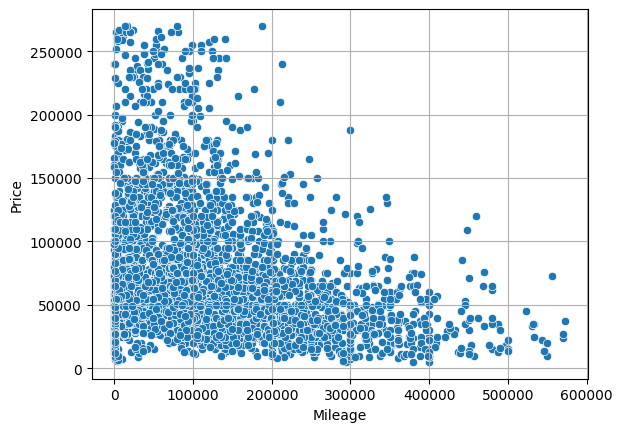

In [19]:
plt.figure()
sns.scatterplot(
    data=df,
    x='Year',
    y='Price'
)
plt.grid()

plt.show()

plt.figure()
sns.scatterplot(
    data=df,
    x='Engine_Size',
    y='Price'
)
plt.grid()

plt.show()

plt.figure()
sns.scatterplot(
    data=df,
    x='Mileage',
    y='Price'
)
plt.grid()

plt.show()

# **Modeling**

At this stage, we will search for the best model and select it to be implemented in the machine learning process for predicting the price of used cars.

## Initial Feature Strategy

Based on the data, we will proceed with implementing the initial strategy for manipulating features. In this phase, we will focus on feature selection, encoding, and scaling to achieve the best prediction score. The strategy can be described as follows:


- Type -> Binary Encoding
- Region -> **DROP**
- Make -> Binary Encoding
- Gear_Type -> One Hot Encoding
- Origin -> One Hot Encoding
- Options -> One Hot Encoding
- Year -> Robust Scaler
- Engine_Size -> Robust Scaler
- Mileage -> Robust Scaler
- Negotiable -> **DROP**
- Price -> **TARGET**

---

- Binary Encoding -> 'Type', 'Make'
- One Hot Encoding -> 'Gear_Type', 'Origin', 'Options'

- Robust Scaler -> 'Year', 'Engine_Size', 'Mileage'


- **DROP** -> 'Region', 'Negotiable'

## Data Spliting

In this section, we will choose the features and target variable based on the previously defined strategy. These selected features and the target variable will then be split into appropriate training and testing datasets.

In [20]:
X = df.drop(['Type','Negotiable','Price'], axis=1)
y = df['Price']

In [21]:
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,  
    test_size=0.2,
    random_state=1)

## Column Transformer

In this section, we construct a Column Transformer that combines encoding and scaling techniques to create a preprocessing flow for machine learning. This column transformer will be used to transform the features of the dataset before feeding them into the learning algorithm.

In [22]:
# Membuat Column Transformer

transformer = ColumnTransformer([
    ('binaryEncdr', ce.BinaryEncoder(), ['Make','Region']),
    ('oneHotEncdr', OneHotEncoder(), ['Gear_Type', 'Origin', 'Options']),
    ('robustSclr', StandardScaler(),['Year', 'Engine_Size', 'Mileage'])
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('binaryEncdr', BinaryEncoder(),
                                 ['Make', 'Region']),
                                ('oneHotEncdr', OneHotEncoder(),
                                 ['Gear_Type', 'Origin', 'Options']),
                                ('robustSclr', StandardScaler(),
                                 ['Year', 'Engine_Size', 'Mileage'])])

## Model Benchmarking

At this stage, the data will be trained on seven different models. From these models, the best two will be selected to serve as the final models for the machine learning process.

In [23]:
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)
xgb = XGBRegressor(random_state=0)


# Voting
voting_model = VotingRegressor(estimators=[
    ('clf1', lr),
    ('clf2', knn),
    ('clf3', dt)
])

# stacking

stacking_model = StackingRegressor(
    estimators= [
        ('clf1', lr),
        ('clf2', knn),
        ('clf3', dt)
    ],
    final_estimator= lr
)

# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_voting_model = TransformedTargetRegressor(voting_model, func=np.log, inverse_func=np.exp)
log_stacking_model = TransformedTargetRegressor(stacking_model, func=np.log, inverse_func=np.exp)

## Data Training for Model Benchmarking

In [24]:
list_model = [log_lr, log_knn, log_dt, log_rf, log_xgb, log_voting_model, log_stacking_model]
name_list_model = ['logreg', 'knn', 'tree', 'random forest', 'xgb', 'voting', 'stacking']

list_all = []

list_rsme_score = []
list_rmse_mean = []
list_rmse_std = []

list_mae_score = []
list_mae_mean = []
list_mae_std = []

list_mape_score = []
list_mape_mean = []
list_mape_std = []

for model in list_model:
    pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    # RMSE
    cv_score_rmse = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train,
        cv = 5,
        scoring='neg_root_mean_squared_error',
        error_score='raise'
    )

    list_rsme_score.append(cv_score_rmse.round(2))
    list_rmse_mean.append(cv_score_rmse.round(2).mean())
    list_rmse_std.append(cv_score_rmse.round(2).std())

    # MAE
    cv_score_mae = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train,
        cv = 5,
        scoring='neg_mean_absolute_error',
        error_score='raise'
    )

    list_mae_score.append(cv_score_mae.round(2))
    list_mae_mean.append(cv_score_mae.round(2).mean())
    list_mae_std.append(cv_score_mae.round(2).std())

    #MAPE
    cv_score_mape = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train,
        cv = 5,
        scoring='neg_mean_absolute_percentage_error',
        error_score='raise'
    )

    list_mape_score.append(cv_score_mape.round(2))
    list_mape_mean.append(cv_score_mape.round(2).mean())
    list_mape_std.append(cv_score_mape.round(2).std())

In [47]:
df_cv = pd.DataFrame()
df_cv['Algorithm'] = name_list_model
df_cv['RMSE_mean'] = list_rmse_mean
df_cv['RMSE_std'] = list_rmse_std
df_cv['RMSE_score_all'] = list_rsme_score

df_cv['MAE_mean'] = list_mae_mean
df_cv['MAE_std'] = list_mae_std
df_cv['MAE_score_all'] = list_mae_score

df_cv['MAPE_mean'] = list_mape_mean
df_cv['MAPE_std'] = list_mape_std
df_cv['MAPE_score_all'] = list_mape_score
df_cv.sort_values('MAPE_mean',ascending=False)

,Algorithm,RMSE_mean,RMSE_std,RMSE_score_all,MAE_mean,MAE_std,MAE_score_all,MAPE_mean,MAPE_std,MAPE_score_all
4,xgb,-24071.640,868.103623,"[-24387.14, -24990.33, -22420.91, -24199.83, -...",-14774.680,606.735305,"[-15211.22, -15117.98, -14921.82, -13576.03, -...",-0.228,0.011662,"[-0.24, -0.23, -0.22, -0.21, -0.24]"
3,random forest,-26839.848,882.762974,"[-26440.11, -27484.26, -25982.74, -28241.31, -...",-16245.766,430.607813,"[-16455.1, -16811.4, -16476.29, -15791.52, -15...",-0.244,0.013565,"[-0.27, -0.24, -0.24, -0.23, -0.24]"
6,stacking,-28685.560,1238.227960,"[-28330.49, -30214.59, -26967.39, -29982.81, -...",-17410.612,643.381136,"[-17370.78, -18599.75, -17381.24, -16964.82, -...",-0.268,0.007483,"[-0.28, -0.27, -0.27, -0.26, -0.26]"
5,voting,-29396.594,1303.243962,"[-28767.39, -30572.39, -27560.44, -31161.84, -...",-17811.786,547.715643,"[-17693.9, -18884.11, -17612.21, -17510.01, -1...",-0.276,0.010198,"[-0.29, -0.28, -0.27, -0.28, -0.26]"
1,knn,-30415.212,954.049881,"[-29892.51, -31968.42, -31032.57, -29842.8, -2...",-19332.606,850.334460,"[-19227.68, -20577.52, -19991.14, -18391.42, -...",-0.324,0.008000,"[-0.32, -0.33, -0.33, -0.33, -0.31]"
0,logreg,-36542.204,1727.768971,"[-34435.64, -37875.81, -36851.49, -38836.4, -3...",-22825.398,598.775869,"[-22590.0, -23358.05, -23633.94, -22579.42, -2...",-0.342,0.011662,"[-0.35, -0.33, -0.33, -0.36, -0.34]"
2,tree,-37558.582,1446.503570,"[-38092.59, -39099.03, -35012.63, -37016.29, -...",-21851.078,1130.190012,"[-22143.18, -23674.48, -20978.47, -20380.31, -...",-0.356,0.018547,"[-0.39, -0.36, -0.34, -0.35, -0.34]"


In this stage, scores have been obtained for the seven models used. The two best models are selected based on the MAPE scoring. XGB and Random Forest have emerged as the candidate algorithms for the models to be implemented.

In [26]:
df_cv.sort_values('MAPE_mean',ascending=False).head(2)

,Algorithm,RMSE_mean,RMSE_std,RMSE_score_all,MAE_mean,MAE_std,MAE_score_all,MAPE_mean,MAPE_std,MAPE_score_all
4,xgb,-24071.640,868.103623,"[-24387.14, -24990.33, -22420.91, -24199.83, -...",-14774.680,606.735305,"[-15211.22, -15117.98, -14921.82, -13576.03, -...",-0.228,0.011662,"[-0.24, -0.23, -0.22, -0.21, -0.24]"
3,random forest,-26839.848,882.762974,"[-26440.11, -27484.26, -25982.74, -28241.31, -...",-16245.766,430.607813,"[-16455.1, -16811.4, -16476.29, -15791.52, -15...",-0.244,0.013565,"[-0.27, -0.24, -0.24, -0.23, -0.24]"


## Predict to Test Set

The two best models will be tested on the test set to obtain the best scores.

In [27]:
models = {
    'XGB': XGBRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(random_state=0)
}

rmse_score = []
mae_score = []
mape_score = []

for i in models:

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_score.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_score.append(mean_absolute_error(y_test, y_pred))
    mape_score.append(mean_absolute_percentage_error(y_test, y_pred))

temp_score = pd.DataFrame({'RMSE': rmse_score, 'MAE': mae_score, 'MAPE': mape_score}, index=models.keys())
temp_score.sort_values('MAPE',ascending=True)

,RMSE,MAE,MAPE
XGB,22737.608368,15206.469859,0.271522
RandomForest,24197.892608,15668.360154,0.280039


During the prediction on the test set, XGBoost performs slightly better in terms of the score compared to RandomForest, although the difference in scores is not significant. This can be observed from the slightly lower MAPE value of XGBoost compared to RandomForest.

## Hyperparameter Tuning

Based on the testing conducted above, XGBoost has been selected as the algorithm of choice to be the model for the machine learning implementation. To further enhance the model's performance, hyperparameter tuning will be performed with the aim of reducing the MAPE score.

#### Hyperparameter Tuning

The following are the parameters of the model that will undergo tuning:

In [28]:
# The maximum depth of each tree
max_depth = list(np.arange(1, 11))

# Controls the step size at each boosting iteration
learning_rate = list(np.arange(1, 100)/100)

# The number of boosting stages or trees to build
n_estimators = list(np.arange(100, 501))

# The fraction of samples used for training each tree
subsample = list(np.arange(2, 10)/10)

# Minimum loss reduction required to make a further partition on a leaf node
gamma = list(np.arange(1, 11))

# The fraction of features used for training each tree
colsample_bytree = list(np.arange(1, 10)/10)

# L1 regularization term on weights
reg_alpha = list(np.logspace(-3, 1, 10))


# Hyperparam space XGboost
hyperparam_space_xgb = {
    'model__max_depth': max_depth, 
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
    'model__gamma': gamma,
    'model__colsample_bytree': colsample_bytree,
    'model__reg_alpha': reg_alpha,
    'model__reg_alpha': reg_alpha
}

#### Benchmark with Hyperparameter Tuning

In this stage, the model will undergo tuning for each of the selected parameters using the Randomized Search technique. The goal of this process is to obtain the best parameters to be implemented in the model.

In [38]:
xgb = XGBRegressor(random_state=1, verbosity=0)

estimator_xgb = Pipeline([
        ('preprocessing', transformer),
        ('model', xgb)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=1)

random_xgb = RandomizedSearchCV(
    estimator_xgb, 
    param_distributions = hyperparam_space_xgb,
    cv = crossval,
    n_iter = 100,
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error',
    random_state = 0
)

random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binaryEncdr',
                                                                               BinaryEncoder(),
                                                                               ['Make',
                                                                                'Region']),
                                                                              ('oneHotEncdr',
                                                                               OneHotEncoder(),
                                                                               ['Gear_Type',
                                                                                'Origin',
                                                                                'Options']),
                                                                              ('robustSclr',
                                                                               StandardScaler(),
                                                                               ['Year',
                                                                                'Engine_Size',
                                                                                'Mileage'])])),...
                                                             0.007742636826811269,
                                                             0.021544346900318832,
                                                             0.05994842503189409,
                                                             0.1668100537200059,
                                                             0.46415888336127775,
                                                             1.2915496650148828,
                                                             3.593813663804626,
                                                             10.0],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9]},
                   random_state=0, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [39]:
pd.DataFrame(random_xgb.cv_results_).sort_values(by=['rank_test_neg_mean_absolute_percentage_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_root_mean_squared_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
36,1.374048,0.175982,0.035624,0.005887,0.9,0.001,122,8,0.05,5,...,812.795146,1,-0.250781,-0.258042,-0.238219,-0.258859,-0.252223,-0.251625,0.007407,1
25,1.347281,0.019555,0.038215,0.003668,0.5,0.001,130,9,0.05,5,...,727.945293,4,-0.257858,-0.257535,-0.258285,-0.266628,-0.251308,-0.258323,0.004879,2
35,1.702728,0.087738,0.042794,0.009809,0.6,0.059948,177,7,0.08,7,...,766.015894,3,-0.260327,-0.258378,-0.250202,-0.263949,-0.259736,-0.258518,0.004548,3
78,3.568713,0.257672,0.052379,0.013566,0.8,0.002783,468,7,0.04,7,...,627.707800,2,-0.263257,-0.258244,-0.253683,-0.268799,-0.256754,-0.260147,0.005319,4
71,4.286557,0.121798,0.060270,0.016603,0.9,0.021544,316,8,0.28,9,...,942.827265,5,-0.268543,-0.264826,-0.239623,-0.280749,-0.273819,-0.265512,0.014008,5


In [40]:
print('XGBoost')
print('Best Score:', random_xgb.best_score_)
print('Best Parameter:', random_xgb.best_params_)

XGBoost
Best Score: -22729.953351313736
Best Parameter: {'model__subsample': 0.8, 'model__reg_alpha': 0.0027825594022071257, 'model__n_estimators': 468, 'model__max_depth': 7, 'model__learning_rate': 0.04, 'model__gamma': 7, 'model__colsample_bytree': 0.6}


In this stage, the best parameters will be tested on the test data to observe the changes in the MAPE score after the hyperparameter tuning process.

In [41]:
model = {'XGB': XGBRegressor(random_state=1)}

xgb_tuning = random_xgb.best_estimator_

xgb_tuning.fit(X_train, y_train)

y_pred_xgb_tuning = xgb_tuning.predict(X_test)

rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=model.keys())
score_after_tuning

,RMSE,MAE,MAPE
XGB,20849.452273,13816.262108,0.243962


In [42]:
pd.DataFrame({
    'Before':temp_score.loc['XGB'],
    'After': [score_after_tuning['RMSE'][0],score_after_tuning['MAE'][0],score_after_tuning['MAPE'][0]]
})

,Before,After
RMSE,22737.608368,20849.452273
MAE,15206.469859,13816.262108
MAPE,0.271522,0.243962


After undergoing hyperparameter tuning, the model was able to decrease the previously obtained MAPE score. The results of the tuned model can be observed using the scatterplot shown below.

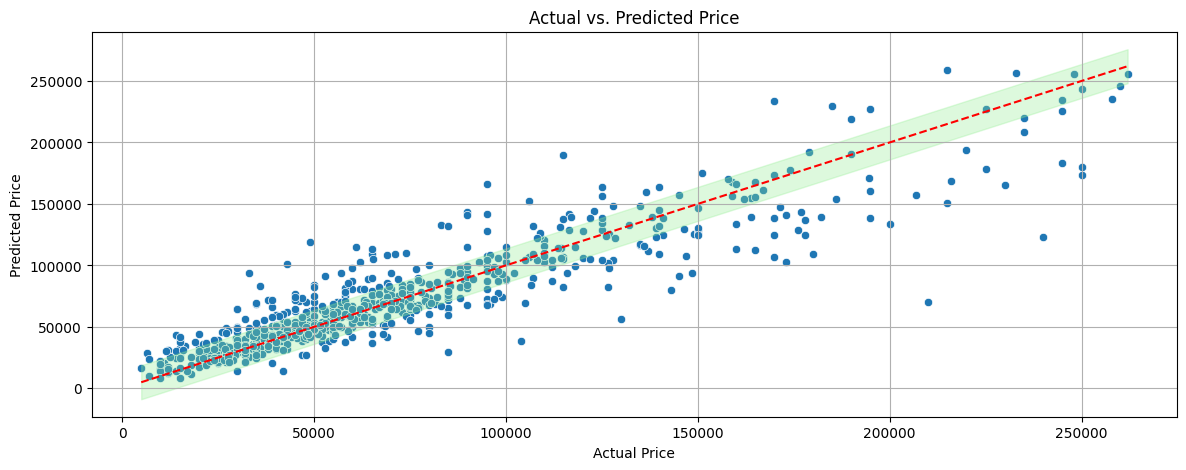

In [53]:
error_threshold = mae_xgb_tuning

plt.figure(figsize=(14, 5))
plot = sns.scatterplot(x=y_test, y=y_pred_xgb_tuning)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Add the line x=y
plt.fill_between([y_test.min(), y_test.max()], [y_test.min() - error_threshold, y_test.max() - error_threshold], [y_test.min() + error_threshold, y_test.max() + error_threshold], color='lightgreen', alpha=0.3)  # Add the safe zone
plot.set(title='Actual vs. Predicted Price', xlabel='Actual Price', ylabel='Predicted Price')
plt.grid()
plt.show()

From the graph above, it can be visually observed that the predicted and actual prices tend to align well for used cars with prices below 100,000. The data points are still close to the linear line x=y, indicating a good alignment between the predicted and actual values.

### Feature Importances

With the implemented model, the following are the feature components considered significant by the machine learning model.

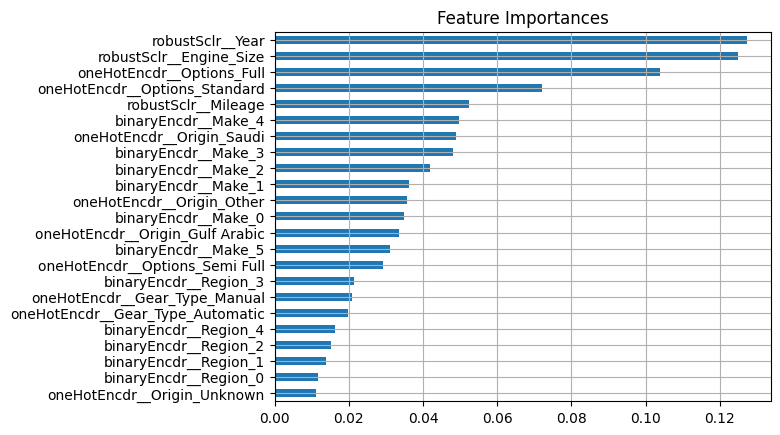

In [44]:
plt.figure()
feature_imp = pd.Series(xgb_tuning['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = True)
feature_imp.plot(kind='barh', title='Feature Importances').grid()
plt.show()

## Deploy Model

In [45]:
import pickle
pickle.dump(xgb_tuning, open('Model_CarUsed_Syara.sav', 'wb'))

In [46]:
loaded_model = pickle.load(open('Model_CarUsed_Syara.sav', 'rb'))
mean_absolute_percentage_error(y_test, loaded_model.predict(X_test))

0.24396164186481778

# **Conclusion and Recommendation**

## Conclusion
1. In achieving the objectives stated earlier, the following conclusions can be drawn:

    - `Develop a machine learning model for predicting the prices of used cars in the Saudi Arabian market.`

        A machine learning model has been successfully developed to predict the prices of used cars using the XGBoost algorithm, achieving an error level of approximately 0.24 when evaluated using the MAPE metric. This indicates that the predictions may deviate by up to 25% in either direction from the actual prices.
        <br>
    - `Identify the variables that significantly affect the pricing of used cars in the Saudi Arabian market.`

        Based on the information from the "Feature Importance" graph, the top 5 influential features in price formation, in descending order, are:
        1. Year
        2. Option (Full)
        3. Engine Size
        4. Option (Standar)
        5. Option (Semi Full)

        Meanwhile, the bottom 5 features are:

        1. Origin (Unknown)
        2. Region (1)
        3. Region (0)
        4. Gear_Type (Automatic)
        5. Region (2)
        <br><br>
2. Price predictions tend to align well for used cars priced below SAR 100,000. The data points are still close to the linear line x=y. 

3. With all the features used in the dataset, no single feature is found to be significantly essential overall. Even the highest-ranking features show values around 0.13 on a scale of 0-1, indicating relatively balanced importance among the features.



## Recommendation


In general, a model with an error rate of ~24% can be implemented as an initial step for a Price prediction product to be launched by Syarah. However, for future improvements and to enhance the performance of the existing model, we recommend the following steps:

1. Increase training data: Collecting a larger volume of diverse training data can provide the model with more examples and patterns to learn from. This can help improve its ability to generalize and make accurate predictions on unseen data.
2. Perform hyperparameter tuning: Utilize advanced computing resources and techniques to perform an extensive hyperparameter tuning process. This involves systematically exploring different combinations of hyperparameters and selecting the ones that yield the best performance. Grid search, random search, or Bayesian optimization can be employed to efficiently search the hyperparameter space.
3. Add additional features: Incorporate additional relevant features that can provide valuable information for predicting used car prices. This may include factors like color, seating capacity, service history, car type, accident history, or any other variables that have a significant impact on pricing. Thorough research and domain knowledge can help identify the most relevant features to include.
4. Explore polynomial features: Consider introducing polynomial features to capture more complex relationships between the features and the target variable. By including polynomial terms, the model can potentially capture non-linear patterns in the data and improve its predictive performance. Experiment with different degrees of polynomial features and assess their impact on the model's accuracy.

By implementing these recommendations, the model's performance can be enhanced, leading to more accurate predictions of used car prices. It is important to experiment, evaluate, and iterate on these steps to continually improve the model's performance over time.